In [1]:
!pip install deeplake

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
import deeplake
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
ds = deeplake.load("hub://activeloop/mnist-train")

|

Opening dataset in read-only mode as you don't have write permissions.


This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-train



\

hub://activeloop/mnist-train loaded successfully.



In [4]:
labels = np.array(ds['labels'])
images = np.array(ds['images'])

In [5]:
# Разбиение данных на тренировочный и тестовый наборы
mnist_train_X, mnist_test_X, mnist_train_y, mnist_test_y = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
mnist_train_X = mnist_train_X / 255
mnist_test_X = mnist_test_X / 255

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

filtered_train_images = train_images[train_labels < 5]
filtered_test_images = test_images[test_labels < 5]
filtered_train_labels = train_labels[train_labels < 5]
filtered_test_labels = test_labels[test_labels < 5]

In [8]:
fashion_train_X = filtered_train_images / 255
fashion_test_X = filtered_test_images / 255

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Задание 1
Обучиться на mnist цифрах и перенести модель, дообучить на mnist одежда (5 классов)

In [10]:
# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
flattened = Flatten()(decoded)
out = Dense(10, activation='softmax')(flattened)

optimizer = Adam(learning_rate=0.001)
# Сборка автоэнкодера
autoencoder = Model(input_img, out)
autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [11]:
mnist_train_y = tf.keras.utils.to_categorical(mnist_train_y, 10)
mnist_test_y = tf.keras.utils.to_categorical(mnist_test_y, 10)

In [12]:
autoencoder.fit(mnist_train, mnist_train_y,
                epochs=25,
                batch_size=100,
                validation_data=(mnist_test, mnist_test_y))

Epoch 1/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.7232 - loss: 0.8638 - val_accuracy: 0.9662 - val_loss: 0.1134
Epoch 2/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.9725 - loss: 0.0914 - val_accuracy: 0.9747 - val_loss: 0.0873
Epoch 3/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9794 - loss: 0.0666 - val_accuracy: 0.9829 - val_loss: 0.0551
Epoch 4/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9850 - val_loss: 0.0517
Epoch 5/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.9896 - loss: 0.0359 - val_accuracy: 0.9847 - val_loss: 0.0509
Epoch 6/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.9908 - loss: 0.0292 - val_accuracy: 0.9881 - val_loss: 0.0383
Epoch 7/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.9930 - loss: 0.0227 - val_accuracy: 0.9887 - val_loss: 0.0367
Epoch 8/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.9938 - loss: 0.0198 - 

In [13]:
predicted_labels = autoencoder.predict(mnist_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [14]:
from sklearn.metrics import classification_report

prediction_y = np.argmax(predicted_labels, axis=-1)
mnist_test_y_1 = np.argmax(mnist_test_y, axis=-1)
# Получаем отчет о классификации
report = classification_report(mnist_test_y_1, prediction_y)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1175
           1       1.00      1.00      1.00      1322
           2       0.99      0.99      0.99      1174
           3       1.00      0.99      0.99      1219
           4       0.99      0.99      0.99      1176
           5       0.99      0.99      0.99      1104
           6       0.99      1.00      1.00      1177
           7       0.99      0.99      0.99      1299
           8       0.99      0.99      0.99      1160
           9       0.99      0.99      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [15]:
new_autoencoder_fashion = Model(input_img, autoencoder.layers[-1].output)
for layer in new_autoencoder_fashion.layers:
    layer.trainable = False

x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model_from_numbers = Model(input_img, predictions)
fashion_model_from_numbers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model_from_numbers.fit(fashion_train_X, filtered_train_labels,
                               epochs=35,
                               batch_size=100,
                               validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions_from_numbers = fashion_model_from_numbers.predict(fashion_test_X)

Epoch 1/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7721 - loss: 0.6008 - val_accuracy: 0.8454 - val_loss: 0.4111
Epoch 2/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8717 - loss: 0.3410 - val_accuracy: 0.8680 - val_loss: 0.3545
Epoch 3/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8854 - loss: 0.3081 - val_accuracy: 0.8744 - val_loss: 0.3404
Epoch 4/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8880 - loss: 0.2902 - val_accuracy: 0.8802 - val_loss: 0.3292
Epoch 5/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8971 - loss: 0.2742 - val_accuracy: 0.8772 - val_loss: 0.3282
Epoch 6/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8985 - loss: 0.2661 - val_accuracy: 0.8834 - val_loss: 0.3214
Epoch 7/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9060 - loss: 0.2498 - val_accuracy: 0.8806 - val_loss: 0.3211
Epoch 8/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9060 - loss: 0.2481 - val_accu

In [16]:
prediction_fashion_y = np.argmax(predictions_from_numbers, axis=-1)
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, prediction_fashion_y)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1000
           1       0.98      0.97      0.98      1000
           2       0.86      0.82      0.84      1000
           3       0.92      0.85      0.88      1000
           4       0.77      0.90      0.83      1000

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



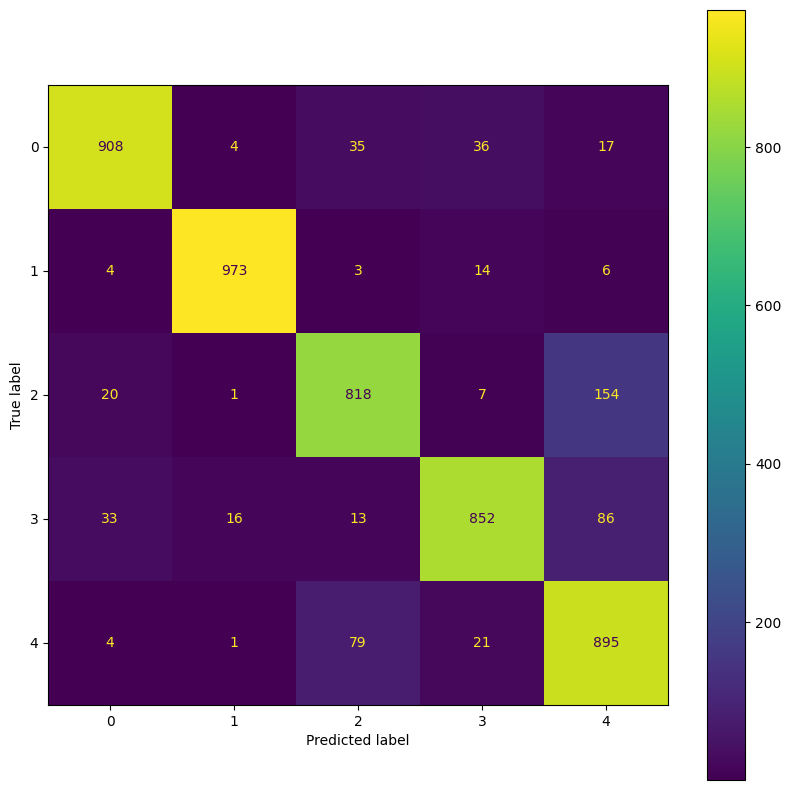

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, prediction_fashion_y)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

# Задание 2
Обучиться на мнист цифры с self target и перенести на одежду (5 классов)



In [18]:
# ЗАДАНИЕ 2

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [19]:
# Обучение автоэнкодера
autoencoder.fit(mnist_train, mnist_train,
                epochs=35,
                batch_size=256,
                validation_data=(mnist_test, mnist_test))

Epoch 1/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - loss: 0.2037 - val_loss: 0.0786
Epoch 2/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - loss: 0.0779 - val_loss: 0.0733
Epoch 3/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.0729 - val_loss: 0.0712
Epoch 4/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 0.0713 - val_loss: 0.0705
Epoch 5/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - loss: 0.0702 - val_loss: 0.0693
Epoch 6/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - loss: 0.0691 - val_loss: 0.0687
Epoch 7/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - loss: 0.0689 - val_loss: 0.0683
Epoch 8/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.0685 - val_loss: 0.0678
Epoch 9/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 0.0681 - val_loss: 0.0675
Epoch 10/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.0677 - val_loss: 0.0672
Epoch 11/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - loss: 0.0675 - val_loss: 0.0670
Epoch 12/35
188/188

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


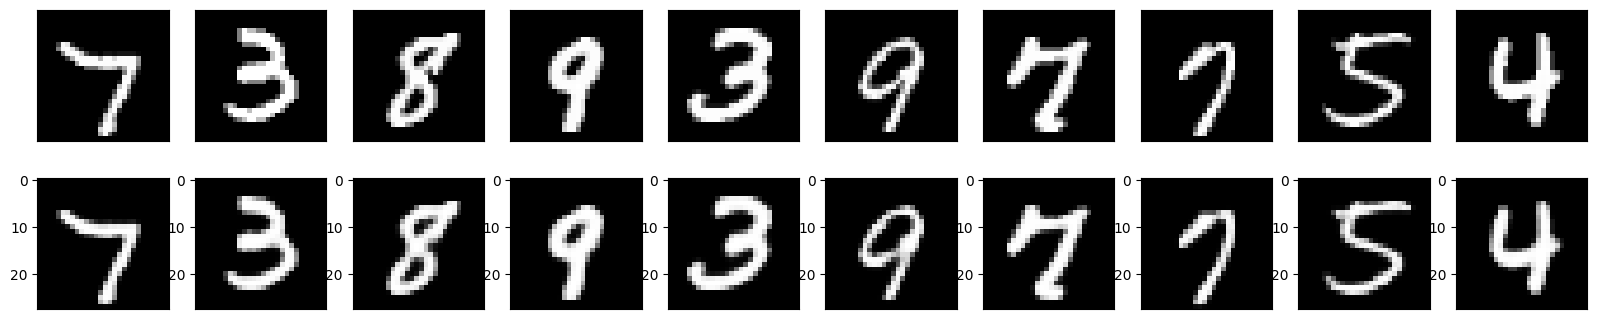

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [21]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(fashion_train_X, filtered_train_labels,
                  epochs=35,
                  batch_size=256,
                  validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test_X)

Epoch 1/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7494 - loss: 0.6858 - val_accuracy: 0.8764 - val_loss: 0.3537
Epoch 2/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8877 - loss: 0.3181 - val_accuracy: 0.8824 - val_loss: 0.3251
Epoch 3/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8995 - loss: 0.2812 - val_accuracy: 0.9010 - val_loss: 0.2843
Epoch 4/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9057 - loss: 0.2623 - val_accuracy: 0.8972 - val_loss: 0.2823
Epoch 5/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9105 - loss: 0.2453 - val_accuracy: 0.8756 - val_loss: 0.3219
Epoch 6/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9111 - loss: 0.2422 - val_accuracy: 0.9088 - val_loss: 0.2615
Epoch 7/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9166 - loss: 0.2305 - val_accuracy: 0.9062 - val_loss: 0.2562
Epoch 8/35
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9185 - loss: 0.2219 - val_accu

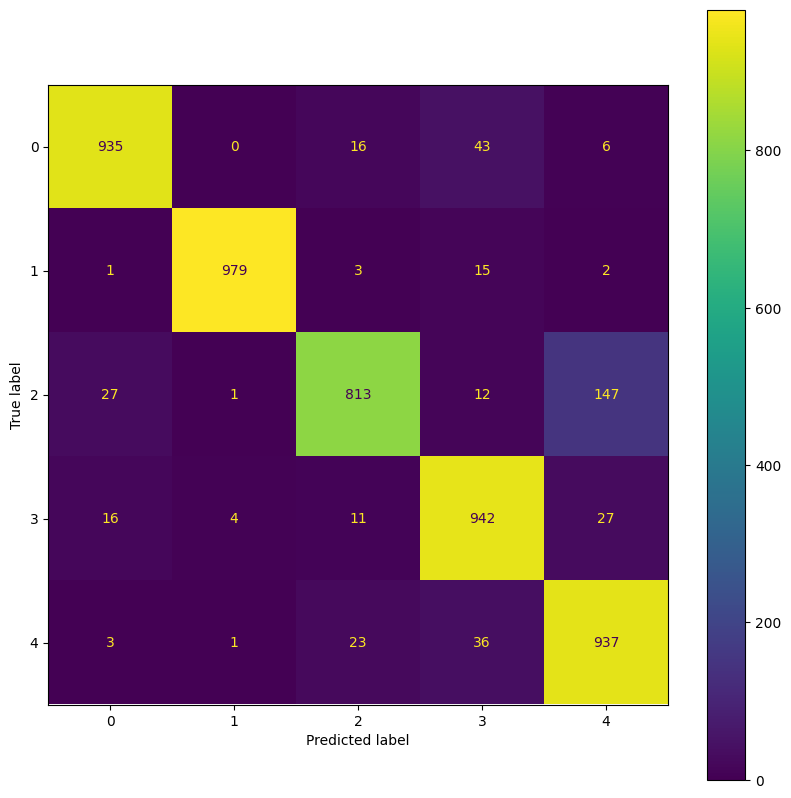

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

In [23]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(filtered_test_labels, predicted_labels, average='macro')

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.92
Recall: 0.92
F1-score: 0.92


In [24]:
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1000
           1       0.99      0.98      0.99      1000
           2       0.94      0.81      0.87      1000
           3       0.90      0.94      0.92      1000
           4       0.84      0.94      0.88      1000

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



# Задание 3
Попробовать сделать полносвязную сеть для классификации mnist цифры

In [25]:
# Загрузка и предобработка данных
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
mnist_train = mnist_train_X.astype('float32') / 255.
mnist_test = mnist_test_X.astype('float32') / 255.

mnist_train = mnist_train.reshape(-1, 28, 28, 1)
mnist_test = mnist_test.reshape(-1, 28, 28, 1)

# Архитектура автоэнкодера
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

x = Dense(256, activation='relu')(encoded)
x = Dense(512, activation='relu')(x)
x = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.001)
# Обучение автоэнкодера на MNIST
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
autoencoder.fit(mnist_train, mnist_train,
                epochs=50,
                batch_size=512,
                validation_data=(mnist_test, mnist_test))

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7564 - loss: 0.0931 - val_accuracy: 0.8074 - val_loss: 0.0321
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8084 - loss: 0.0279 - val_accuracy: 0.8085 - val_loss: 0.0201
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8119 - loss: 0.0181 - val_accuracy: 0.8124 - val_loss: 0.0143
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8133 - loss: 0.0143 - val_accuracy: 0.8123 - val_loss: 0.0131
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8137 - loss: 0.0125 - val_accuracy: 0.8134 - val_loss: 0.0111
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8141 - loss: 0.0110 - val_accuracy: 0.8135 - val_loss: 0.0099
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8144 - loss: 0.0099 - val_accuracy: 0.8136 - val_loss: 0.0092
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8145 - loss: 0.0092 - val_accu

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


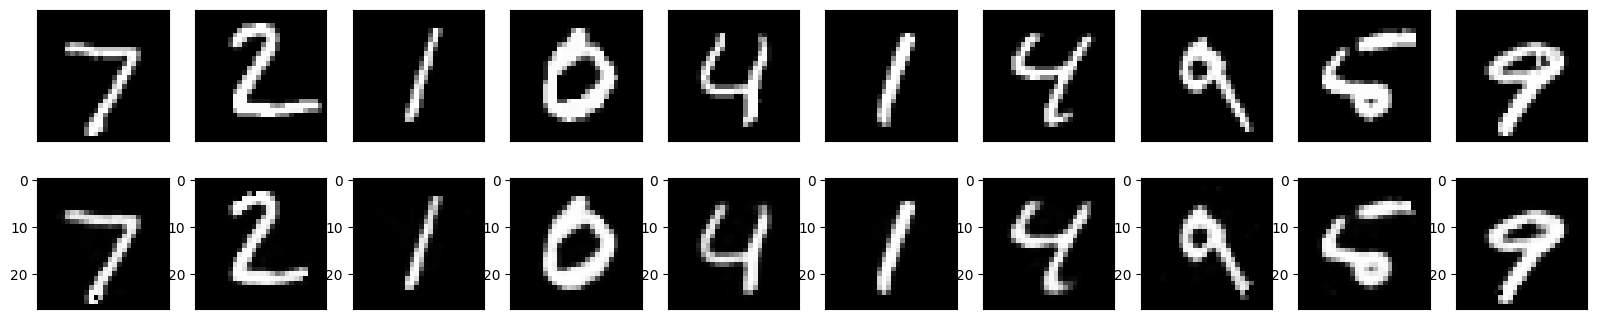

In [26]:
# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [27]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

model = Model(input_img, predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(mnist_train, mnist_train_y,
          epochs=30,
          batch_size=256,
          validation_data=(mnist_test, mnist_test_y))

# Предсказание
predictions = model.predict(mnist_test)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5378 - loss: 1.6190 - val_accuracy: 0.8898 - val_loss: 0.3910
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8840 - loss: 0.3936 - val_accuracy: 0.9088 - val_loss: 0.3196
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9032 - loss: 0.3240 - val_accuracy: 0.9186 - val_loss: 0.2840
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9160 - loss: 0.2907 - val_accuracy: 0.9266 - val_loss: 0.2585
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9242 - loss: 0.2582 - val_accuracy: 0.9333 - val_loss: 0.2322
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9318 - loss: 0.2333 - val_accuracy: 0.9360 - val_loss: 0.2224
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9381 - loss: 0.2146 - val_accuracy: 0.9406 - val_loss: 0.2009
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.1998 - val_accuracy: 0.

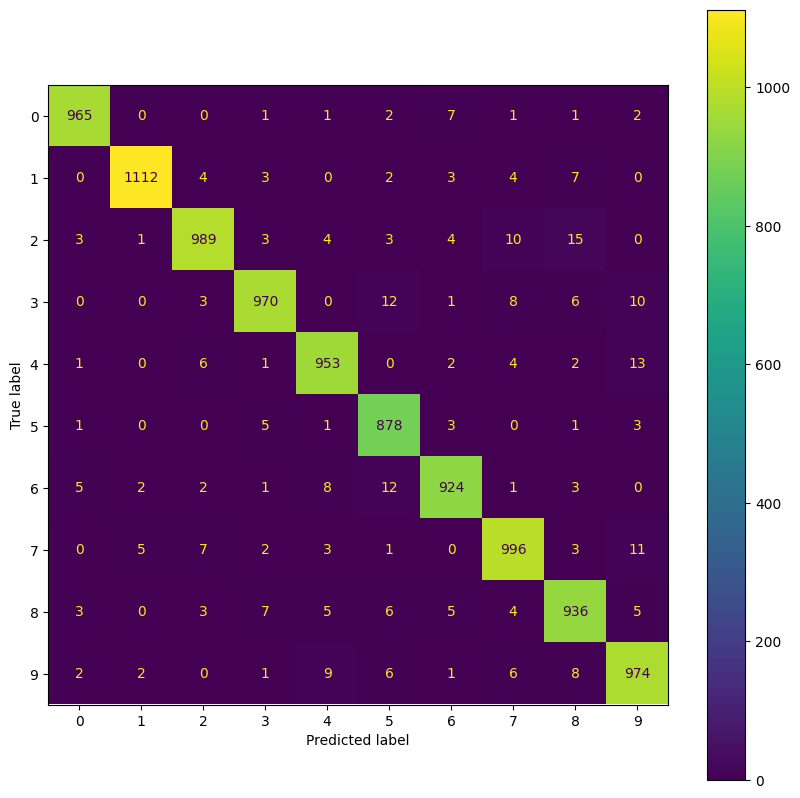

In [28]:
# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(mnist_test_y, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(ax=ax)
plt.show()

In [29]:
# Получаем отчет о классификации
report = classification_report(mnist_test_y, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.95      0.98      0.97       892
           6       0.97      0.96      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.95      0.96      0.96       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

